In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from PIL import Image
from scipy.io import loadmat  
from scipy import stats  
from scipy.stats import multivariate_normal
import re
import glob
from operator import itemgetter 
import random

from support_functions import *
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model

Using TensorFlow backend.


## Read Data

In [2]:
label_1_folder = [9,21]      # Images in this folder will be labeled as anomaly
target_folders = range(1,21) # Read these folders
data_path = "CroppedYale/"   # Source folder

# Read image matrix (n*m), labels (vector of m), and image size
imgs, labels, height, width = get_data(label_1_folder,target_folders,data_path)

544  images are above our threshold and thus removed from the list


### Load the Saved Deep Net Models
#### First, get the autoencoder model

In [3]:
# Generate and Compile a Deep Autoencoder
img_size = height*width
autoencoder, encoder = compile_autoencoder(imgs, img_size)
autoencoder = load_model('model_autoencoder.h5') # Load the saved model

#### Second, set the weights of the encoder model with the first half of autoencoder model

In [4]:
weights_encoder = autoencoder.get_weights()[0:2] # The first half of the autoencoder model is an encoder model
encoder.set_weights(weights_encoder) # Set weights

In [5]:
print(encoder.summary())
print("\n The output shape of the encoder model: ")
print(encoder.output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 504)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4040      
Total params: 4,040
Trainable params: 4,040
Non-trainable params: 0
_________________________________________________________________
None

 The output shape of the encoder model: 
(None, 8)


### Visualize the Reconstructed Image

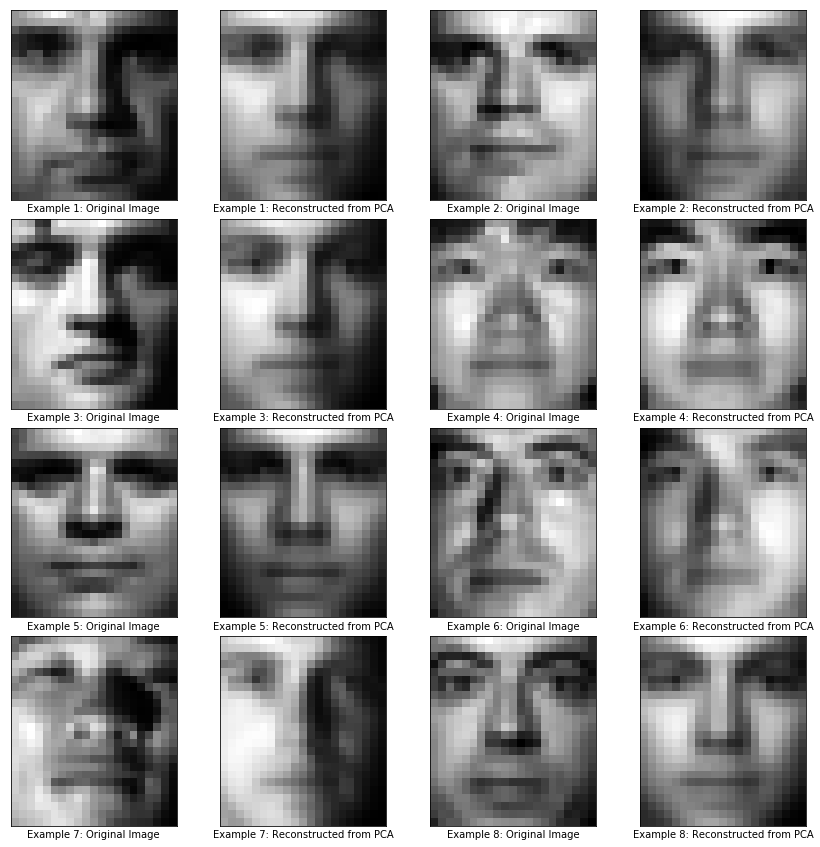

In [6]:
imgs_trans = np.transpose(imgs) # Transpose
imgs_trans = imgs_trans.astype('float32') / 255. # Normalize the Data
# Load into the model and get the processed output
imgs_reconst = np.transpose(autoencoder.predict(imgs_trans))

# Plot the original images and their reconstructed version for comparison
plot_compare_after_reconst(imgs_reconst,imgs,height,width)

## Implement the Anomaly Detection 
### Split the data into the Training and Testing sets

In [7]:
# Split the images and labels
# By default: 80% in training and 20% in testing
train_ind, test_ind = split_training(labels)
x_all = np.transpose(imgs)
x_train = x_all[train_ind,:]
x_test = x_all[test_ind,:]
labels_train = labels[train_ind]
labels_test = labels[test_ind]

# Normalize the Data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

### Method 1: Anomaly Detection with the Reconstruction Error
Reconstruct both the training and testing data with Deep Autoencoder

In [8]:
# Reconstruct both training and testing data with Deep Autoencoder
reconst_train = np.transpose(autoencoder.predict(x_train))
reconst_test = np.transpose(autoencoder.predict(x_test))

The higher the reconstruction error, the more likely the point will be an anomaly


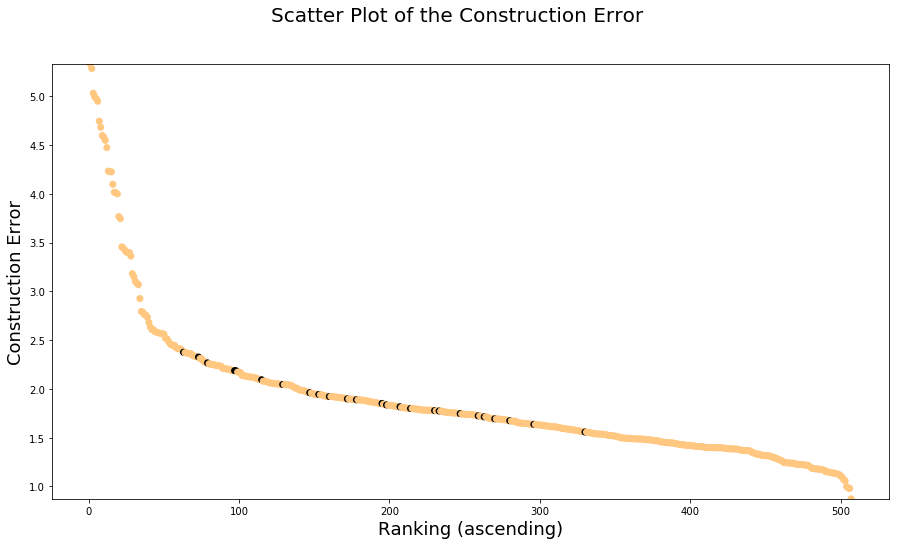

In [9]:
# Find the euclidean distance between the reconstructed dataset and the original ()
dist_train = find_euclidean_distance(reconst_train,np.transpose(x_train))
print("The higher the reconstruction error, the more likely the point will be an anomaly")
plot_scatter_with_labels(dist_train,labels_train, 'Construction Error')

In [10]:
k = 20 # Define the k parameter for the precision at k
threshold_reconst_error = select_threshold_distance(dist_train, labels_train, k, to_print = True)

Precision: 8.2%
Recall: 92.0%
F-score: 15.0%
Precision@20: 0.0%


### Evaluate the Detector with the Testing Dataset

In [11]:
# Find the euclidean distance between the reconstructed dataset and the original ()
dist_test = find_euclidean_distance(reconst_test,np.transpose(x_test))

# Sort the Images and Labels based on the Probability
rank_test = np.argsort(-dist_test) # Sort from the Largest to the Smallest
dist_test_ranked = dist_test[rank_test] # Sort the distance
labels_test_ranked = labels_test[rank_test] # Rank Labels

# Give Predictions
preds = np.zeros(labels_test.shape) # Initialization
preds[dist_test_ranked > threshold_reconst_error] = 1

# Evaluate the Detector with Testing Data
eval_with_test(preds, labels_test_ranked, k = k)

Precision: 6.5%
Recall: 83.3%
F-score: 10.8%
Precision@20: 0.0%


### Method 2: Anomaly Detection with the Gaussian Distribution

#### Encode the images in the Training Set and the Testing Set

In [12]:
# Pass the training data into the decoder model
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)

#### Visualize the Distribution of Data Points in the encoded matrix
To observe the scale and the Gaussian property 

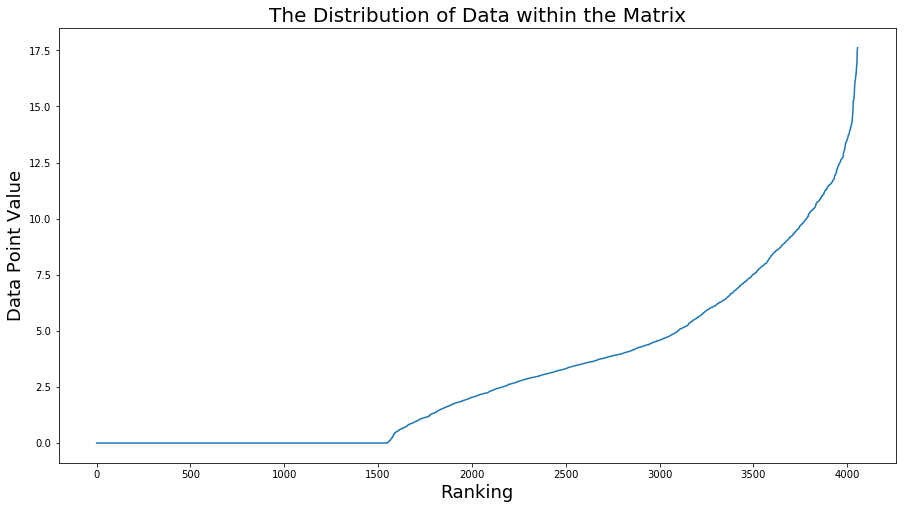

In [13]:
plot_matrix_data(encoded_train)

#### Fit a Gaussian Distribution Model with the Training Set

In [14]:
# Get Gaussian Distribution Model for the Validation Data
# Note: fit_multivariate_gaussian() is my own coded function
dist_train = fit_multivariate_gaussian(encoded_train)

LinAlgError: singular matrix

#### Visualize the Distribution of the Anomaly vs. Normal Set through Scatterplot

In [ ]:
# Get Probability of being Anomaly vs. being Normal
p_train = dist_train.pdf(encoded_train)   # Probability of Being Normal
# Plot the Probability with labels
plot_scatter_with_labels(p_train, labels_train,'Gaussian Probability')

In [ ]:
# Train the Anomaly Detector
threshold_gaussian  = select_threshold_probability(p_train, labels_train,k,to_print = True)

#### Apply to the testing set

In [ ]:
# Find the euclidean distance between the reconstructed dataset and the original ()
p_test = dist_train.pdf(encoded_test)   # Probability of Being Normal

# Sort the Images and Labels based on the Probability
rank_test = np.argsort(p_test) # Sort from the Smallest to the Largest
p_test_ranked = p_test[rank_test] # Sort the distance
labels_test_ranked = labels_test[rank_test] # Rank Labels

# Give Predictions
preds = np.zeros(labels_test.shape) # Initialization
preds[p_test_ranked < threshold_gaussian] = 1 # If the probability is smaller than the threshold, marked as anomaly

# Evaluate the Detector with Testing Data
eval_with_test(preds, labels_test_ranked, k = k)